In [1]:
%matplotlib widget
import pynance
from pathlib import Path
import torch
import sklearn
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

saving_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

In [2]:
# next line should be commented
from pydatatools.utils import user
data_path = Path(user.get_item_from_user_cfg(section="pie", item="path_to_data"))
results_path = Path(user.get_item_from_user_cfg(section="pie", item="path_to_results"))
results_path.mkdir(parents=True, exist_ok=True)

## Market stock future prediction

Demo notebook. Naive training, plotting etc.

### Get and save data

This will not come from this notebook (data is created and transformed from the data module). Only the path as below should be used.

In [ ]:
# df = pd.read_excel(data_path / "dataEurope.xlsx") # NOT what we want for market ...

# market_name = "^CAC"
# import pandas_datareader.data as pdr
# from datetime import date, datetime
# end = date.today()
# start = datetime(year=end.year-2, month=end.month-1, day=end.day)
# # More information of the datasource:
# df = pdr.get_data_stooq(market_name, start, end)
# df['Close'].plot(title='1 year price history for index CAC40')
# df = df.interpolate(inplace=True) # replace missing data with linear interpolation...


### Define dataset

In [ ]:
path = data_path / f"cac40_norm.csv" # cac40 with Close "normalize" (x - mean)/std
dtype = torch.float
device = torch.device("cpu")
window = 100
batch_size = 16

data_creator = pynance.utils.datasets.creators.StockValuePredictionDatasetCreator(path)
train_set, valid_set = data_creator.get_train_sets(ratio=0.8, return_type="torch", window=200)

collater = pynance.utils.datasets.collaters.TimeSeriesCollater(dtype=dtype, device=device)

training_loader = torch.utils.data.DataLoader(
                            train_set,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=4,
                            collate_fn=collater)
validation_loader = torch.utils.data.DataLoader(
                            valid_set,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=4,
                            collate_fn=collater)

### Models

In [ ]:
# defining the RNN model
rnn = pynance.model.forecasting.TFnaive(
    input_size=1,
    hidden_size=2,
    num_layers=2
).to(device=device, dtype=dtype)


### Training

In [ ]:
# Optim
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [ ]:
pynance.utils.train.train(
    epochs=10,
    model=rnn,
    loss_fn=loss_function,
    training_loader=training_loader,
    validation_loader=validation_loader,
    optimizer=optimizer,
    saving_path=results_path,
    saving_name="try1"
)

### "Test" the model

In [ ]:
state_dict_path = results_path/"model_state_dict_try1_20221203_150021_96.pt"

df = pd.read_csv(path, parse_dates=["Date"]).sort_values(by="Date")
X_test = torch.DoubleTensor(df["Close"].values).to(device=device, dtype=dtype)
X_test = torch.unsqueeze(torch.unsqueeze(X_test, dim=0), dim=-1)

# state_dict = torch.load(state_dict_path)
# rnn.load_state_dict(state_dict)

In [ ]:
out = rnn.predict(X_test, window=100)

In [19]:
# to make dates for the predictions
# TODO: init_date is not enough in case there is NaN values.
# How to handle precisely NaN values ? 
# I believe we should make an average with the one before and the one after.
# See : http://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
# Remember : data is perfect, not my job to perform cleaning...
def make_dates(init_date, length_preds):
    dates = []
    dt = datetime.timedelta(days=1.)
    date = init_date
    while(len(dates) < length_preds):
        date += dt
        if(date.isoweekday() <= 5):
            dates.append(date)
    return dates

In [ ]:
preds = torch.cat([out[1], out[0][:, X_test.shape[1]:]], dim=1).cpy().numpy()[0, :, 0]
dates = make_dates(df["Date"].iloc[0], len(preds))

In [ ]:
# plotting truth vs predictions
fig, ax = plt.subplots()
sns.lineplot(data=df, x="Date", y="Close", label="true")
sns.lineplot(x=dates, y=preds, label="pred")
plt.xticks(rotation=45);

## Regression Models

### Data

In [3]:
# https://finance.yahoo.com/quote/%5EFCHI/components?p=%5EFCHI
import pandas_datareader.data as web 
from sklearn import linear_model

end = datetime.date.today()
start = datetime.datetime(year=end.year-3, month=end.month, day=end.day)
market = '^FCHI'
stocks = ['ATO.PA', 'ACA.PA', 'ML.PA']
test_market_and_stocks = [market] + stocks
path = data_path / "cac40_stocks.csv"

def get_stock(data):
    df = data["Close"].copy(deep=True)
    df.interpolate(inplace=True)
    return df

# TODO : do something about normalization
# data = web.DataReader(test_market_and_stocks, 'yahoo', start=start, end=end)
# df = get_stock(data)
# df.to_csv(path)


In [4]:
data_creator = pynance.utils.datasets.creators.StockValueRegressionDatasetCreator(path, path, market="^FCHI")

In [5]:
x_train, x_valid, y_train, y_valid = data_creator.get_train_sets(ratio=0.8, return_type="numpy")

In [6]:
regs = {}
for i, stock in enumerate(stocks):
    reg = linear_model.LinearRegression()
    reg = reg.fit(x_train, y_train[:, i:i+1])
    regs[stock] = reg
    score = reg.score(x_valid, y_valid[:, i:i+1])
    print(f"{stock} : {score}")


ATO.PA : 0.2672399088053824
ACA.PA : 0.6335273355247785
ML.PA : 0.7552427023821663


In [7]:
dates = data_creator.test_df["Date"]
x_test, y_test = data_creator.get_test_set(return_type="numpy")

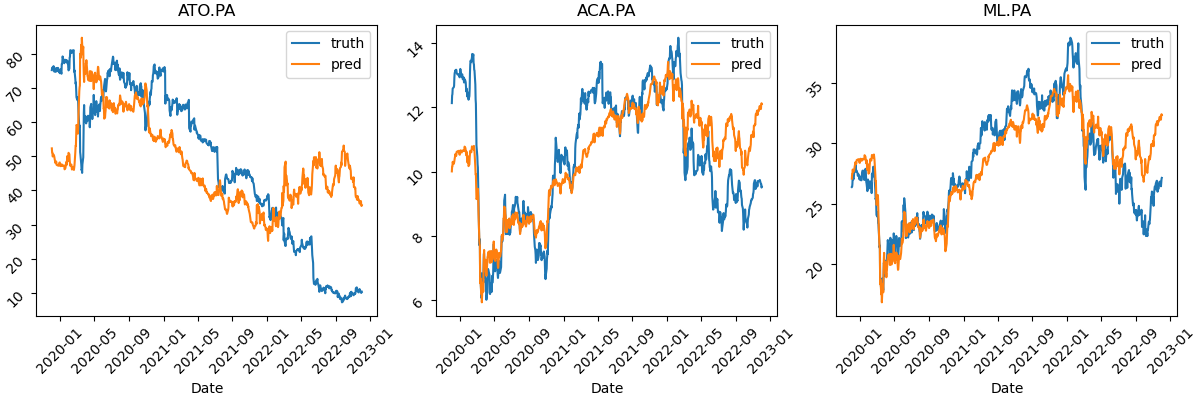

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4), constrained_layout=True)
for i, (stock, reg) in enumerate(regs.items()):
    preds = reg.predict(x_test)
    sns.lineplot(x=dates, y=np.squeeze(y_test[:, i:i+1]), label="truth", ax=ax[i])
    sns.lineplot(x=dates, y=np.squeeze(preds), label="pred", ax=ax[i])
    ax[i].set_title(stock)
    ax[i].tick_params(labelrotation=45)
